## NLP Tutorial

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this tutorial we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [4]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [5]:
train_df.tail()

id keyword location  \
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1

In [6]:
train_df.shape

(7613, 5)

In [7]:
test_df.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [8]:
test_df.shape

(3263, 4)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

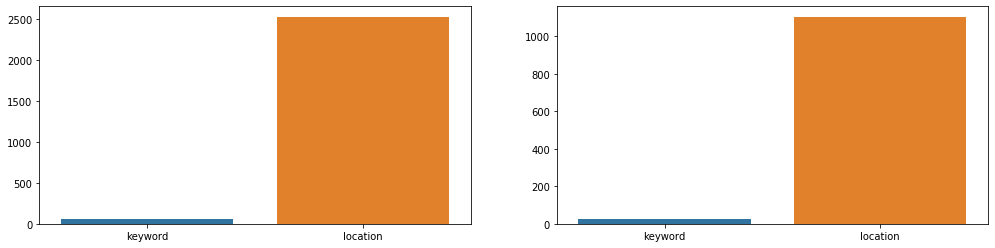

In [10]:
missing_cols = ['keyword','location']

fig,axes = plt.subplots(ncols=2, figsize=(17,4))

sns.barplot(x=train_df[missing_cols].isnull().sum().index, y=train_df[missing_cols].isnull().sum().values,ax=axes[0])
sns.barplot(x=test_df[missing_cols].isnull().sum().index, y=test_df[missing_cols].isnull().sum().values,ax=axes[1])

plt.show()




In [11]:
train_df['keyword'].nunique()

221

In [12]:
train_df['location'].nunique()

3341

Meta Features 


In [13]:
train_df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [14]:
### Word count 

train_df['word_count'] = train_df['text'].apply(lambda x : len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

In [15]:
### Unique Word Count

train_df['unique_word_count'] = train_df['text'].apply(lambda x : len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

In [16]:
from wordcloud import STOPWORDS

In [17]:
### Stop Word Count

train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [18]:
### Mean word length

train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [19]:
### Hashtag Count

train_df['hash_tag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hash_tag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [20]:
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

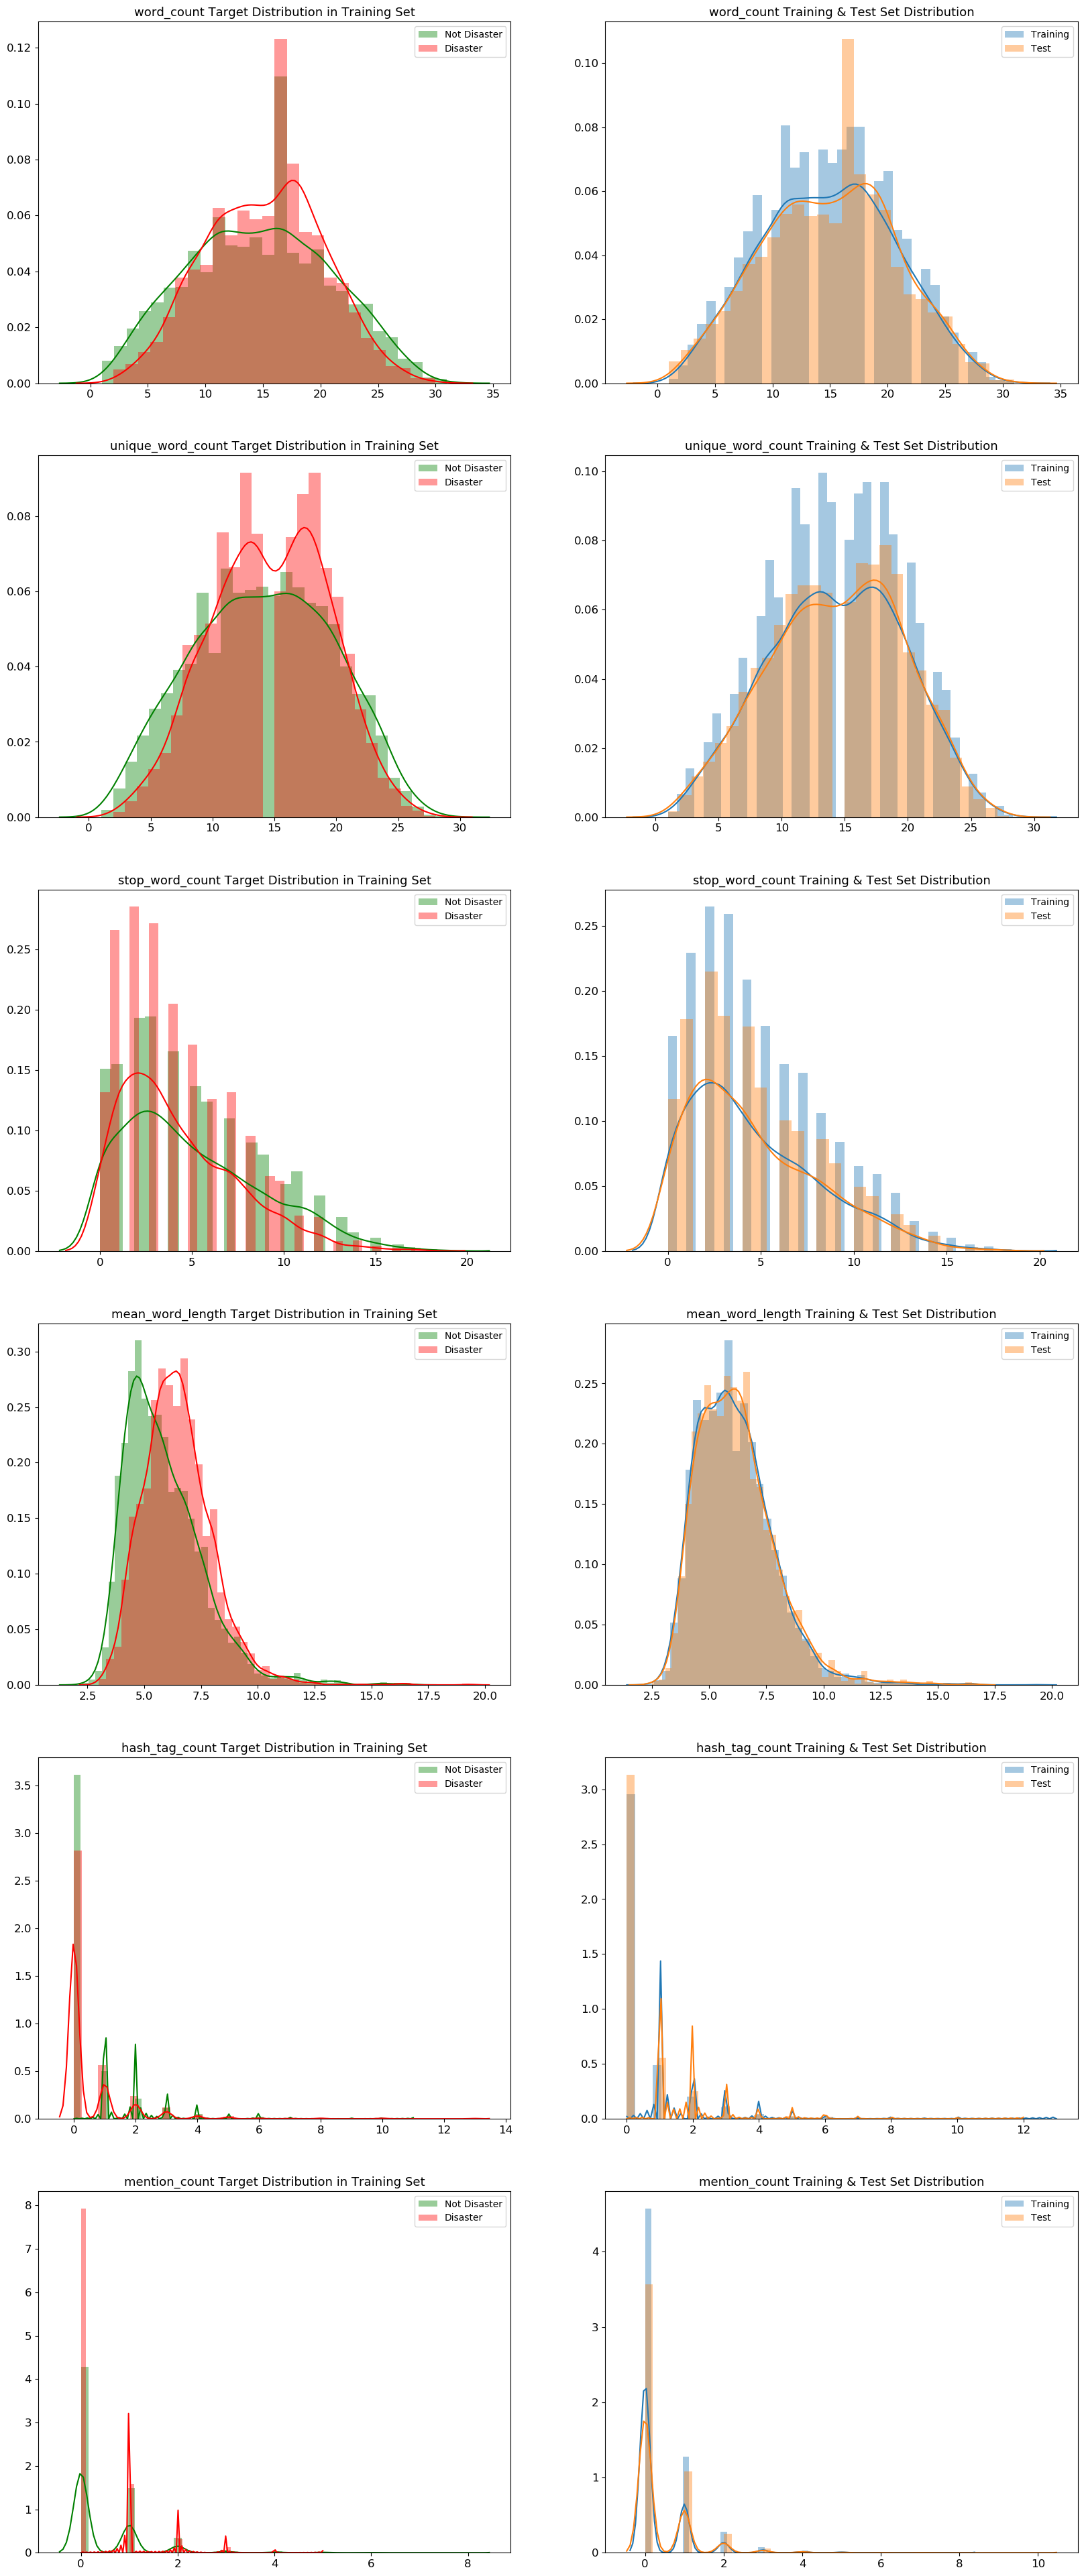

In [21]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',
                 'hash_tag_count', 'mention_count']
DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [22]:
train_df.groupby('target').count()['id']

target
0    4342
1    3271
Name: id, dtype: int64

classes are almost equally seperated

### Data Cleansing

In [23]:
df = pd.concat([train_df,test_df])

/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [24]:
import re

In [25]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)



In [26]:
df['text']=df['text'].apply(lambda x : remove_url(x))

### Removing Emojis

In [27]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [28]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [29]:
df_train = df[:train_df.shape[0]]
df_test = df[train_df.shape[0]:]

In [30]:
df_test.shape

(3263, 11)

In [31]:
df_train.head()

hash_tag_count  id keyword location  mean_word_length  mention_count  \
0               1   1     NaN      NaN          4.384615              0   
1               0   4     NaN      NaN          4.571429              0   
2               0   5     NaN      NaN          5.090909              0   
3               1   6     NaN      NaN          7.125000              0   
4               2   7     NaN      NaN          4.500000              0   

   stop_word_count  target                                               text  \
0                6     1.0  Our Deeds are the Reason of this #earthquake M...   
1                0     1.0             Forest fire near La Ronge Sask. Canada   
2               11     1.0  All residents asked to 'shelter in place' are ...   
3                1     1.0  13,000 people receive #wildfires evacuation or...   
4                7     1.0  Just got sent this photo from Ruby #Alaska as ...   

   unique_word_count  word_count  
0                 13          13  
1                  7           7  
2                 20          22  
3                  8           8  
4                 15          16

### Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

Note: a `vector` is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['target'], test_size = 0.3, random_state = 1)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)

In [35]:
from sklearn import svm
svm = svm.SVC(C=1000)
svm.fit(X_train, y_train)

/Users/ikyathvarmadantuluri/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [36]:
from sklearn.metrics import confusion_matrix
X_test = vectorizer.transform(X_test)
y_pred = svm.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[1272   54]
 [ 456  502]]


In [37]:
test_vectors = vectorizer.transform(df_test['text'])

In [39]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [40]:
sample_submission["target"] = svm.predict(test_vectors)

In [43]:
sample_submission.describe

<bound method NDFrame.describe of          id  target
0         0     0.0
1         2     0.0
2         3     1.0
3         9     0.0
4        11     1.0
5        12     0.0
6        21     0.0
7        22     0.0
8        27     0.0
9        29     0.0
10       30     0.0
11       35     0.0
12       42     0.0
13       43     0.0
14       45     0.0
15       46     0.0
16       47     0.0
17       51     0.0
18       58     0.0
19       60     0.0
20       69     0.0
21       70     1.0
22       72     0.0
23       75     0.0
24       84     0.0
25       87     0.0
26       88     0.0
27       90     0.0
28       94     0.0
29       99     1.0
...     ...     ...
3233  10756     1.0
3234  10757     1.0
3235  10758     1.0
3236  10761     1.0
3237  10762     1.0
3238  10773     1.0
3239  10778     1.0
3240  10781     1.0
3241  10791     0.0
3242  10792     0.0
3243  10796     0.0
3244  10797     0.0
3245  10801     0.0
3246  10804     0.0
3247  10806     0.0
3248  10807     0.0
3249  

In [42]:
sample_submission.to_csv("submission.csv", index=False)

In [102]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(df_train["text"][0:5])

In [103]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


The above tells us that:
1. There are 54 unique words (or "tokens") in the first five tweets.
2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

Now let's create vectors for all of our tweets.

In [104]:
train_vectors = count_vectorizer.fit_transform(df_train["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(df_test["text"])

In [119]:
type(train_vectors)

scipy.sparse.csr.csr_matrix

### Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a _linear_ connection. So let's build a linear model and see!

In [105]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

Let's test our model and see how well it does on the training data. For this we'll use `cross-validation` - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [117]:
scores = model_selection.cross_val_score(clf, train_vectors, df_train["target"], cv=5, scoring="f1")
scores

array([0.61497326, 0.48141892, 0.57142857, 0.53043478, 0.65813253])

The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - give any of them a shot!

In the meantime, let's do predictions on our training set and build a submission for the competition.

In [118]:
clf.fit(train_vectors, df_train["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [108]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [109]:
sample_submission["target"] = clf.predict(test_vectors)

In [110]:
sample_submission.head()

id  target
0   0     0.0
1   2     1.0
2   3     1.0
3   9     1.0
4  11     1.0

In [111]:
sample_submission.to_csv("submission.csv", index=False)

Now, in the viewer, you can submit the above file to the competition! Good luck!